In [1]:
# Data processing
import numpy as np
import pandas as pd
import xarray as xr
import scipy
import iris
import iris.pandas
from iris.experimental import stratify
from iris.analysis import trajectory
import warnings
warnings.filterwarnings('ignore', module='iris')
from pathlib import Path
import dateutil.parser
from datetime import datetime, timedelta
# Visualization
import cartopy.util
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
# Scientific parameters
M_air = 28.97 # molar mass of dry air [kg]
# Coefficients to convert mass mixing ratio to volume mixing ratio
coeff_c2h6 = (M_air/30.0690)*1e12 # Ethane_WAS
coeff_c3h8 = (M_air/44.0956)*1e12 # Propane_WAS
coeff_nc4h10 = (M_air/58.1222)*1e12 # n-Butane_WAS
coeff_ic4h10 = (M_air/58.1222)*1e12 # i-Butane_WAS
coeff_nc5h12 = (M_air/72.1488)*1e12 # n-Pentane_WAS
coeff_ic5h12 = (M_air/72.1488)*1e12 # i-Pentane_WAS
coeff_meono2 = (M_air/77.0394)*1e12 # MeONO2_WAS
coeff_sbuono2 = (M_air/119.1192)*1e12 # 2-BuONO2_WAS or sBuONO2
coeff_n2peono2 = (M_air/133.1457)*1e12 # 2-PenONO2_WAS or n2PeONO2 or nPeBONO2
coeff_n3peono2 = (M_air/133.1457)*1e12 # 3-PenONO2_WAS or n3PeONO2 or nPeCONO2
coeff_ipeono2 = (M_air/133.1457)*1e12 # 3-Methyl-2-BuONO2_WAS or iPeONO2 or iPeBONO2
# Plotting parameters
plt.rcParams['mathtext.default'] = 'regular'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 20
savefig = True
# Species names
str_c2h6 = '$C_2H_6$'; str_c3h8 = '$C_3H_8$'
str_nc4h10 = '$nC_4H_{10}$'; str_ic4h10 = '$iC_4H_{10}$'
str_nc5h12 = '$nC_5H_{12}$'; str_ic5h12 = '$iC_5H_{12}$'
str_meono2 = '$MeONO_2$'; str_sbuono2 = '2-$BuONO_2$'
str_n2peono2 = '2-$PenONO_2$'; str_n3peono2 = '3-$PenONO_2$'; str_ipeono2 = '3-Methyl-2-$BuONO_2$'

#### Read data

In [2]:
path_to_atom = Path('../../external_data/ATom/nc/data')
# Select flights
flist_atom_flights = ['MER-WAS_DC8_20170218_R8.nc', 'MER-WAS_DC8_20170219_R7.nc', 'MER-WAS_DC8_20170221_R8.nc']
fpaths_atom_flights = [path_to_atom / i for i in flist_atom_flights]
# Read ATom data
atom_dsinf = xr.open_mfdataset(fpaths_atom_flights, decode_times=True)
atom_dsmms = xr.open_mfdataset(fpaths_atom_flights, group='MMS', decode_cf=True)
atom_dswas = xr.open_mfdataset(fpaths_atom_flights, group='WAS', decode_cf=True)

In [3]:
# Choose UKCA run parameters
ukca_run_name = 'ba897'; ukca_run_freq = 'T1H'; ukca_run_mnth = '201702'; lvs = 'thlevs'

path_to_ukca = Path('../data') / ukca_run_name
fname_ukca_run = f'{ukca_run_name}_{ukca_run_freq}_{ukca_run_mnth}_{lvs}.nc'
# Read UKCA data
cb_c2h6 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'C2H6 MASS MIXING RATIO AFTER TSTEP')*coeff_c2h6
cb_c3h8 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'C3H8 MASS MIXING RATIO AFTER TSTEP')*coeff_c3h8
cb_nc4h10 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'n-C4H10 MASS MIXING RATIO AFTER TS')*coeff_nc4h10
cb_ic4h10 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'i-C4H10 MASS MIXING RATIO AFTER TS')*coeff_ic4h10
cb_nc5h12 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'n-C5H12 MASS MIXING RATIO AFTER TS')*coeff_nc5h12
cb_ic5h12 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'i-C5H12 MASS MIXING RATIO AFTER TS')*coeff_ic5h12
cb_meono2 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'MeONO2 MASS MIXING RATIO AFTER TSTEP')*coeff_meono2
cb_sbuono2 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 's-BuONO2 MASS MIXING RATIO AFTER TS')*coeff_sbuono2
cb_n2peono2 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'n-2PeONO2 MASS MIXING RATIO AFTER TS')*coeff_n2peono2
cb_n3peono2 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'n-3PeONO2 MASS MIXING RATIO AFTER TS')*coeff_n3peono2
cb_ipeono2 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'i-PeONO2 MASS MIXING RATIO AFTER TS')*coeff_ipeono2
# Load altitude coordinate of UKCA's global domain
_alt_coord = iris.load_cube(str(Path('../data')/'ukca_coords_n96e_marcus_180705.nc'),'mass_fraction_of_ozone_in_air').coord('altitude')

In [4]:
# Extract datetimes from ATom and UKCA data
atom_datetime = atom_dsinf.time.values.astype('<M8[us]').astype(datetime)
atom_date_strt = atom_datetime[0]
atom_date_stop = atom_datetime[-1]
ukca_days_since = dateutil.parser.parse(str(cb_nc4h10.coord('t').units)[11:])
_ukca_datetime = []
for i, ii in enumerate(list(cb_nc4h10.coord('t').points)):
    _ukca_datetime.append(ukca_days_since + timedelta(days=float(f'{ii:1.3f}'))) # UKCA's 'days since 1960-09-01' format is 1.3f
ukca_datetime = np.array(_ukca_datetime, dtype=datetime)
# Create a common timestamp/flight merge identifier for trajectories
compared_common_id = f'{atom_date_strt.strftime("%y%m%d")}_{atom_date_stop.strftime("%y%m%d")}_{ukca_datetime[0].strftime("%y%m")}_merge_zlvs'
print(compared_common_id)

170218_170221_1702_merge_zlvs


In [5]:
# Path to figures
path_to_figs = Path('../../../results') / ukca_run_name / compared_common_id
path_to_figs.mkdir(exist_ok=True) # create a new folder if it doesn't exist

In [6]:
# Construct 3D flights trajectory
sample_time = np.array([(i - ukca_days_since).total_seconds() / 86400. for i in atom_datetime])
sample_lats = atom_dsmms.G_LAT.data 
sample_lons = atom_dsmms.G_LONG.data+360
sample_alts = atom_dsmms.G_ALT.data
sample_time_lats_lons_alts = [('t', sample_time), ('latitude', sample_lats), ('longitude', sample_lons), ('altitude', sample_alts)]

In [7]:
# Convert ATom C2H6, C2H4, C2H2, C3H8, C3H6 to pptvC to match UKCA lumped species, namely C2H6=C2H6+C2H4+C2H2, C3H8=C3H8+C3H6
atom_dswas_c2h6 = atom_dswas['Ethane_WAS']*2 + atom_dswas['Ethene_WAS']*2 + atom_dswas['Ethyne_WAS']*2
atom_dswas_c3h8 = atom_dswas['Propane_WAS']*3 + atom_dswas['Propene_WAS']*3

In [8]:
# Convert xarray dataset with observational data to pandas dataframe
atom_c2h6 = atom_dswas_c2h6.to_dataframe(name='Lumped_C2H6_C2H4_C2H2')
atom_c3h8 = atom_dswas_c3h8.to_dataframe(name='Lumped_C3H8_C3H6')
atom_nc4h10 = atom_dswas['n-Butane_WAS'].to_dataframe()
atom_ic4h10 = atom_dswas['i-Butane_WAS'].to_dataframe()
atom_nc5h12 = atom_dswas['n-Pentane_WAS'].to_dataframe()
atom_ic5h12 = atom_dswas['i-Pentane_WAS'].to_dataframe()
atom_meono2 = atom_dswas['MeONO2_WAS'].to_dataframe()
atom_sbuono2 = atom_dswas['2-BuONO2_WAS'].to_dataframe()
atom_n2peono2 = atom_dswas['2-PenONO2_WAS'].to_dataframe()
atom_n3peono2 = atom_dswas['3-PenONO2_WAS'].to_dataframe()
atom_ipeono2 = atom_dswas['3-Methyl-2-BuONO2_WAS'].to_dataframe()

#### Flight concentrations at all altitudes and model surface concentration (hybrid height level 0) 

In [18]:
# Add a cyclic point to model data for plotting it on a map
cyclic_c2h6, cyclic_lons = cartopy.util.add_cyclic_point(cb_c2h6.data*2, coord=cb_c2h6.coord('longitude').points)
# cyclic_c3h8 = cartopy.util.add_cyclic_point(cb_c3h8.data*3)
cyclic_nc4h10 = cartopy.util.add_cyclic_point(cb_nc4h10.data)
# cyclic_ic4h10 = cartopy.util.add_cyclic_point(cb_ic4h10.data)
# cyclic_nc5h12 = cartopy.util.add_cyclic_point(cb_nc5h12.data)
# cyclic_ic5h12 = cartopy.util.add_cyclic_point(cb_ic5h12.data)
# cyclic_meono2 = cartopy.util.add_cyclic_point(cb_meono2.data)
cyclic_sbuono2 = cartopy.util.add_cyclic_point(cb_sbuono2.data)
# cyclic_n2peono2 = cartopy.util.add_cyclic_point(cb_n2peono2.data)
# cyclic_n3peono2 = cartopy.util.add_cyclic_point(cb_n3peono2.data)
# cyclic_ipeono2 = cartopy.util.add_cyclic_point(cb_ipeono2.data)

/local/mwe14avu/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


In [10]:
# Select longitudes and latitudes where ATom data is available
# lons_c2h6_notnan = np.where(atom_c2h6.Lumped_C2H6_C2H4_C2H2.isna()==False, sample_lons, atom_c2h6.Lumped_C2H6_C2H4_C2H2)
# lats_c2h6_notnan = np.where(atom_c2h6.Lumped_C2H6_C2H4_C2H2.isna()==False, sample_lats, atom_c2h6.Lumped_C2H6_C2H4_C2H2)
# lons_c3h8_notnan = np.where(atom_c3h8.Lumped_C3H8_C3H6.isna()==False, sample_lons, atom_c3h8.Lumped_C3H8_C3H6)
# lats_c3h8_notnan = np.where(atom_c3h8.Lumped_C3H8_C3H6.isna()==False, sample_lats, atom_c3h8.Lumped_C3H8_C3H6)
lons_nc4h10_notnan = np.where(atom_nc4h10['n-Butane_WAS'].isna()==False, sample_lons, atom_nc4h10['n-Butane_WAS'])
lats_nc4h10_notnan = np.where(atom_nc4h10['n-Butane_WAS'].isna()==False, sample_lats, atom_nc4h10['n-Butane_WAS'])
# lons_ic4h10_notnan = np.where(atom_ic4h10['i-Butane_WAS'].isna()==False, sample_lons, atom_ic4h10['i-Butane_WAS'])
# lats_ic4h10_notnan = np.where(atom_ic4h10['i-Butane_WAS'].isna()==False, sample_lats, atom_ic4h10['i-Butane_WAS'])
# lons_nc5h12_notnan = np.where(atom_nc5h12['n-Pentane_WAS'].isna()==False, sample_lons, atom_nc5h12['n-Pentane_WAS'])
# lats_nc5h12_notnan = np.where(atom_nc5h12['n-Pentane_WAS'].isna()==False, sample_lats, atom_nc5h12['n-Pentane_WAS'])
# lons_ic5h12_notnan = np.where(atom_ic5h12['i-Pentane_WAS'].isna()==False, sample_lons, atom_ic5h12['i-Pentane_WAS'])
# lats_ic5h12_notnan = np.where(atom_ic5h12['i-Pentane_WAS'].isna()==False, sample_lats, atom_ic5h12['i-Pentane_WAS'])
# lons_meono2_notnan = np.where(atom_meono2['MeONO2_WAS'].isna()==False, sample_lons, atom_meono2['MeONO2_WAS'])
# lats_meono2_notnan = np.where(atom_meono2['MeONO2_WAS'].isna()==False, sample_lats, atom_meono2['MeONO2_WAS'])
lons_sbuono2_notnan = np.where(atom_sbuono2['2-BuONO2_WAS'].isna()==False, sample_lons, atom_sbuono2['2-BuONO2_WAS'])
lats_sbuono2_notnan = np.where(atom_sbuono2['2-BuONO2_WAS'].isna()==False, sample_lats, atom_sbuono2['2-BuONO2_WAS'])
# lons_n2peono2_notnan = np.where(atom_n2peono2['2-PenONO2_WAS'].isna()==False, sample_lons, atom_n2peono2['2-PenONO2_WAS'])
# lats_n2peono2_notnan = np.where(atom_n2peono2['2-PenONO2_WAS'].isna()==False, sample_lats, atom_n2peono2['2-PenONO2_WAS'])
# lons_n3peono2_notnan = np.where(atom_n3peono2['3-PenONO2_WAS'].isna()==False, sample_lons, atom_n3peono2['3-PenONO2_WAS'])
# lats_n3peono2_notnan = np.where(atom_n3peono2['3-PenONO2_WAS'].isna()==False, sample_lats, atom_n3peono2['3-PenONO2_WAS'])
# lons_ipeono2_notnan = np.where(atom_ipeono2['3-Methyl-2-BuONO2_WAS'].isna()==False, sample_lons, atom_ipeono2['3-Methyl-2-BuONO2_WAS'])
# lats_ipeono2_notnan = np.where(atom_ipeono2['3-Methyl-2-BuONO2_WAS'].isna()==False, sample_lats, atom_ipeono2['3-Methyl-2-BuONO2_WAS'])

In [11]:
# Choose a range that allows to display the variability in lower concentrations
mpglb_c2h6_range = np.arange(0,11000,1000)
mpglb_c3h8_range = np.arange(0,4500,500)
mpglb_nc4h10_range = np.arange(0,450,50)
mpglb_ic4h10_range = np.arange(0,220,20)
mpglb_nc5h12_range = np.arange(0,220,20)
mpglb_ic5h12_range = np.arange(0,220,20)
mpglb_meono2_range = np.arange(0,50,5)
mpglb_sbuono2_range = np.arange(0,11,1)
mpglb_n2peono2_range = np.arange(0,5.5,0.5)
mpglb_n3peono2_range = np.arange(0,5.5,0.5)
mpglb_ipeono2_range = np.arange(0,5.5,0.5)

In [12]:
# Global map plotting parameters
mp_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap='Oranges', extend='max')
mp_sc_kwargs = dict(transform=ccrs.PlateCarree(), c='C0', edgecolors='k', linewidth=0.2)
mp_arrow_kwargs = dict(transform=ccrs.PlateCarree(), color='C0', width=3)
# Add locations where ATom fligths stopped and arrows to show flights general direction
if compared_common_id == '170218_170221_1702_merge_zlvs':
    atom_stops = [dict(name='Palmdale', lon=-118.100556, lat=34.581111),
                  dict(name='Anchorage', lon=-149.9, lat=61.216667),
                  dict(name='Kona', lon=-155.994167, lat=19.65),
                  dict(name='Azores', lon=-25.675556, lat=37.741111),
                  dict(name='Thule', lon=-69.230556, lat=77.466667)]
    mp_arrows = [dict(name='North Atlantic', x=-40, y=20, dx=-5, dy=25)] 
ukca_mp_utc_ind = 425
ukca_datetime_mp_utc = ukca_datetime[ukca_mp_utc_ind].strftime("%d %B %Y %H:%M UTC")

#### RONO2/RH surface map

In [14]:
l = 0
sbuono2_nc4h10 = cyclic_sbuono2[ukca_mp_utc_ind,l,...]/cyclic_nc4h10[ukca_mp_utc_ind,l,...]
# npeono2_nc5h12 = (cyclic_n2peono2[ukca_mp_utc_ind,l,...]+cyclic_n3peono2[ukca_mp_utc_ind,l,...])/cyclic_nc5h12[ukca_mp_utc_ind,l,...]
# ipeono2_ic5h12 = cyclic_ipeono2[ukca_mp_utc_ind,l,...]/cyclic_ic5h12[ukca_mp_utc_ind,l,...]

In [15]:
# check True/False if correct meaning
# lons_npeono2_notnan = np.where(lons_n2peono2_notnan==True, lons_n3peono2_notnan, lons_n2peono2_notnan)
# lats_npeono2_notnan = np.where(lats_n2peono2_notnan==True, lats_n3peono2_notnan, lats_n2peono2_notnan)
sbuono2_nc4h10_notnan_lons = np.where(lons_nc4h10_notnan==True, lons_sbuono2_notnan, lons_nc4h10_notnan)
sbuono2_nc4h10_notnan_lats = np.where(lats_nc4h10_notnan==True, lats_sbuono2_notnan, lats_nc4h10_notnan)
# npeono2_nc5h12_notnan_lons = np.where(lons_nc5h12_notnan==True, lons_npeono2_notnan, lons_nc5h12_notnan)
# npeono2_nc5h12_notnan_lats = np.where(lats_nc5h12_notnan==True, lats_npeono2_notnan, lats_nc5h12_notnan)
# ipeono2_ic5h12_notnan_lons = np.where(lons_ic5h12_notnan==True, lons_ipeono2_notnan, lons_ic5h12_notnan)
# ipeono2_ic5h12_notnan_lats = np.where(lats_ic5h12_notnan==True, lats_ipeono2_notnan, lats_ic5h12_notnan)

In [85]:
rono2_rh_mp_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap='viridis', extend='max')
rono2_rh_mp_sc_kwargs = dict(transform=ccrs.PlateCarree(), c='C1', edgecolors='k', linewidth=0.2, s=100)
rono2_rh_mp_atom_stops_plt_kwargs = dict(transform=ccrs.PlateCarree(), color='C1', marker='^', markeredgecolor='k', markersize=12)
rono2_rh_mp_atom_stops_txt_kwargs = dict(transform=ccrs.PlateCarree(), color='C1', fontsize=18)
# NEEM location
x_helmig2014, y_helmig2014 = -51.10, 77.43
rono2_rh_mp_neem_plt_kwargs = dict(transform=ccrs.PlateCarree(), color='darkseagreen', linewidth=1, marker='o', markeredgecolor='k', markersize=12)
rono2_rh_mp_neem_txt_kwargs = dict(transform=ccrs.PlateCarree(), color='darkseagreen', fontsize=18)

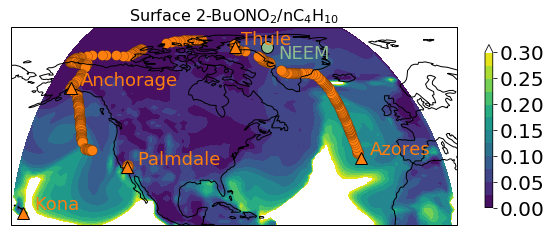

In [86]:
# Plot sampling locations and model surface concentration (hybrid height level 0)
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=270)), facecolor='w')
p1 = ax.contourf(cyclic_lons, cb_sbuono2.coord('latitude').points, sbuono2_nc4h10, levels=np.arange(0,0.325,0.025), **rono2_rh_mp_cf_kwargs)
ax.scatter(sbuono2_nc4h10_notnan_lons, sbuono2_nc4h10_notnan_lats, **rono2_rh_mp_sc_kwargs)
ax.coastlines()
ax.set_title(f'Surface {str_sbuono2}/{str_nc4h10}', fontsize=16)#'\nATom flight track & UKCA {ukca_datetime_mp_utc}')#\nATom vs UKCA {ukca_run_name} hourly')
p1.cmap.set_over('w')
fig.colorbar(p1, shrink=0.3, extend='max')
for i in atom_stops:
    ax.plot(i['lon'], i['lat'], **rono2_rh_mp_atom_stops_plt_kwargs)
    ax.text(i['lon']+4, i['lat']+1, i['name'], **rono2_rh_mp_atom_stops_txt_kwargs)
ax.plot(x_helmig2014, y_helmig2014, **rono2_rh_mp_neem_plt_kwargs)
ax.text(x_helmig2014+3, y_helmig2014-5, 'NEEM', **rono2_rh_mp_neem_txt_kwargs)
# for j in mp_arrows: ax.arrow(j['x'], j['y'], j['dx'], j['dy'], **mp_arrow_kwargs)
if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_mploc_RONO2_RH_C4s_poster.png', bbox_inches='tight')